# Detector Models Comparison

This notebook demonstrates how to compare different detector models in G4LumaCam using the `groupby` functionality.

In [1]:
from lumacam import Config, Simulate, Lens, Analysis
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

## 1. Run Simulation

In [2]:
archive = "demo_models"

config = Config.neutrons_tof(energy_min=1.0, energy_max=10.0)
config.num_events = 1000

sim = Simulate(archive=archive)
sim.run(config)

Simulating:   0%|          | 0/1000 [00:00<?, ?events/s]

,id,parent_id,neutron_id,pulse_id,pulse_time_ns,x,y,z,dx,dy,...,wavelength,parentName,px,py,pz,parentEnergy,nx,ny,nz,neutronEnergy
0,4854,3,8,3,15000.0,-55.1778,-44.5946,16.5396,0.069213,0.082968,...,412.40,proton,-55.1832,-44.6040,16.5143,0.0452,-55.1832,-44.6040,16.5143,2.4834
1,4544,3,8,3,15000.0,-55.1814,-44.6009,16.5225,0.162880,0.049882,...,449.26,proton,-55.1832,-44.6040,16.5143,0.0452,-55.1832,-44.6040,16.5143,2.4834
2,4443,3,8,3,15000.0,-55.1732,-44.5869,16.5606,0.161078,0.098019,...,465.50,proton,-55.1832,-44.6040,16.5143,0.0452,-55.1832,-44.6040,16.5143,2.4834
3,3580,3,8,3,15000.0,-55.1798,-44.5980,16.5303,0.103393,0.054363,...,436.76,proton,-55.1832,-44.6040,16.5143,0.0452,-55.1832,-44.6040,16.5143,2.4834
4,3332,3,8,3,15000.0,-55.1675,-44.5771,16.5871,0.112553,0.124645,...,420.34,proton,-55.1832,-44.6040,16.5143,0.0452,-55.1832,-44.6040,16.5143,2.4834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,9232,2,457,138,690000.0,-19.7743,-21.3572,5.6033,0.030465,0.067016,...,414.27,proton,-19.8459,-21.3298,5.5202,1.9983,-29.4146,-17.2013,16.4625,7.9060
518,6310,2,457,138,690000.0,-19.7611,-21.3622,5.6185,0.089549,0.009618,...,444.78,proton,-19.8459,-21.3298,5.5202,1.9983,-29.4146,-17.2013,16.4625,7.9060
519,16566,2,457,138,690000.0,-19.7051,-21.3833,5.6829,-0.011662,0.027582,...,418.69,proton,-19.8459,-21.3298,5.5202,1.9983,-29.4146,-17.2013,16.4625,7.9060
520,14540,2,457,138,690000.0,-19.6993,-21.3855,5.6895,0.041855,0.058163,...,417.00,proton,-19.8459,-21.3298,5.5202,1.9983,-29.4146,-17.2013,16.4625,7.9060


## 2. Group by Detector Models

Define multiple detector model configurations and group by them.

In [3]:
lens = Lens(archive=archive)

lens.groupby("detector_model", bins=[
    {"name": "intensifier", "detector_model": "image_intensifier", "blob": 2.0, "deadtime": 600},
    {"name": "intensifier_gain", "detector_model": "image_intensifier_gain", "gain": 5000, "blob": 0, "deadtime": 475},
    {"name": "full_physics", "detector_model": "physical_mcp", "gain": 8000, "phosphor_type": "p47", "blob": 0, "deadtime": 475}
])

Loading simulation data:   0%|          | 0/1 [00:00<?, ?it/s]

Grouped by detector_model with 3 configurations
  - intensifier: image_intensifier
  - intensifier_gain: image_intensifier_gain
  - full_physics: physical_mcp


## 3. Trace Rays

Automatically traces rays for all detector models.

In [4]:
lens.trace_rays(seed=42)

Tracing 3 detector model configurations


Processing 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Tracing rays (sim_data_0.csv):   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Tracing rays (sim_data_0.csv):   0%|          | 0/1 [00:00<?, ?it/s]

Processing 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Tracing rays (sim_data_0.csv):   0%|          | 0/1 [00:00<?, ?it/s]

## 4. Process with EMPIR

Automatically detects grouped structure and processes all models.

In [6]:
analysis = Analysis(archive=f"{archive}/detector_model")

analysis.process(
    params="fast_neutrons",
    event2image=False,
    export_photons=True,
    export_events=True,
    export_pixels=True,
    verbosity=1
)

Detected groupby structure: 3 groups
Groupby column: detector_model


Processing groups:   0%|          | 0/3 [00:00<?, ?it/s]

## 5. Compare Results

Load and compare exported data from each model.

In [16]:
# Load photon data from each model
model_names = ["intensifier", "intensifier_gain", "full_physics"]
photon_data = {}
pixel_data = {}

for name in model_names:
    photon_dir = Path(archive) / "detector_model" / name / "ExportedPhotons"
    if photon_dir.exists():
        files = list(photon_dir.glob("*.csv"))
        if files:
            photon_data[name] = pd.read_csv(files[0])

for name in model_names:
    pixel_dir = Path(archive) / "detector_model" / name / "ExportedPixels"
    if pixel_dir.exists():
        files = list(pixel_dir.glob("*.csv"))
        if files:
            pixel_data[name] = pd.read_csv(files[0])

# Compare photon statistics
for name, df in photon_data.items():
    print(f"\n{name}:")
    print(f"  Total photons: {len(df)}")
    if 'tot' in df.columns:
        print(f"  Mean TOT: {df['tot'].mean():.2f} ns")
        print(f"  Std TOT: {df['tot'].std():.2f} ns")

# Compare photon statistics
for name, df in pixel_data.items():
    print(f"\n{name}:")
    print(f"  Total pixel hits: {len(df)}")
    if ' tot [a.u.]' in df.columns:
        print(f"  Mean TOT: {df[' tot [a.u.]'].mean():.2f} ns")
        print(f"  Std TOT: {df[' tot [a.u.]'].std():.2f} ns")


intensifier:
  Total photons: 210

intensifier_gain:
  Total photons: 474

full_physics:
  Total photons: 358

intensifier:
  Total pixel hits: 2197
  Mean TOT: 23.72 ns
  Std TOT: 60.15 ns

intensifier_gain:
  Total pixel hits: 8080
  Mean TOT: 24.41 ns
  Std TOT: 61.64 ns

full_physics:
  Total pixel hits: 8061
  Mean TOT: 18.56 ns
  Std TOT: 42.13 ns


In [17]:
pixel_data["intensifier"].columns

Index(['x [px]', ' y [px]', ' t [s]', ' tot [a.u.]', ' t_relToExtTrigger [s]'], dtype='object')

## 6. Visualize TOT Distributions

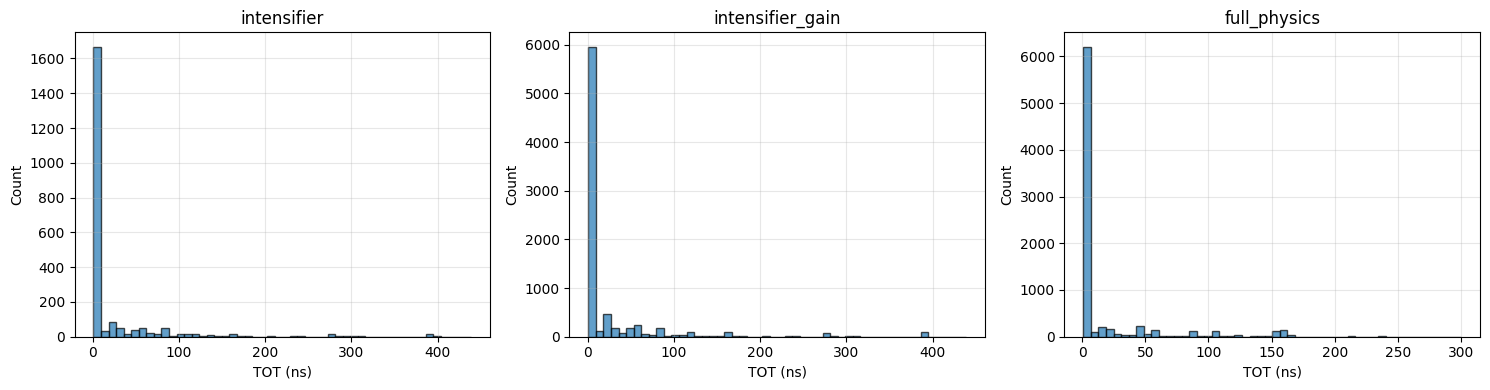

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, (name, df) in zip(axes, pixel_data.items()):
    if ' tot [a.u.]' in df.columns:
        ax.hist(df[' tot [a.u.]'], bins=50, alpha=0.7, edgecolor='black')
        ax.set_xlabel('TOT (ns)')
        ax.set_ylabel('Count')
        ax.set_title(name)
        ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Single Event Visualization

In [45]:
import visualize_pixel_map as vpm

In [35]:
a = vpm.Data('demo_models/detector_model/intensifier_gain/ExportedPhotons/exported_traced_data_0.csv')

Loading CSV file: demo_models/detector_model/intensifier_gain/ExportedPhotons/exported_traced_data_0.csv
Loaded 474 rows


Preparing histograms:   0%|          | 0/153 [00:00<?, ?it/s]

Created 112 histograms


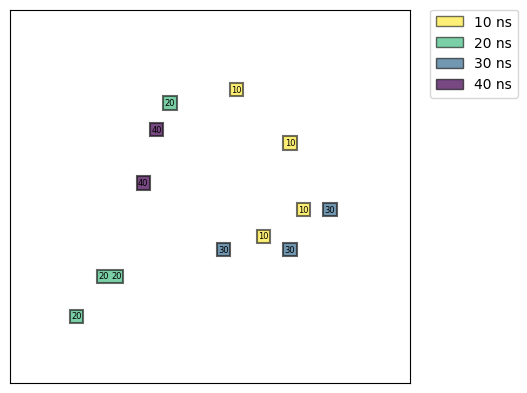

In [44]:
a.plot(3,show_scale=True,show_legend=True,cmap="viridis_r")

## Folder Structure

```
demo_models/
├── SimPhotons/
└── detector_model/
    ├── intensifier/
    │   ├── tpx3Files/
    │   ├── ExportedPhotons/
    │   ├── ExportedEvents/
    │   └── ExportedPixels/
    ├── intensifier_gain/
    │   └── ...
    └── full_physics/
        └── ...
```